# Analysis Introduction

## Overview

This analysis explores the relationship between prescription drug utilization and key health measures at the state level. By cross-referencing specific medications with corresponding health conditions, the analysis aims to uncover patterns and correlations that could inform healthcare policies and decision-making.

---

## Objectives

The primary objectives of this analysis are to:
1. **Examine the correlation** between average drug costs and aggregated health measures across different states.
2. **Identify utilization patterns** of specific drugs in relation to the prevalence of chronic conditions.
3. **Understand the geographic distribution** of prescription drug claims in relation to health outcomes.

---

## Key Questions

To guide the analysis, the following key questions were posed:

### 1. **How do state-level health measures correlate with the average cost of prescription drugs?**
   - Are there states where higher prevalence of certain conditions is associated with increased drug costs?
   - Which conditions show the strongest correlations between health outcomes and prescription costs?

### 2. **What are the total claims for identified drugs across states with different health measures?**
   - How does the utilization of certain drugs vary across states with varying levels of chronic condition prevalence?
   - Are there drugs that are disproportionately prescribed in states with high levels of specific health measures?

### 3. **Which states have the highest and lowest utilization of specific drugs for their corresponding health measures?**
   - What patterns emerge when comparing drug utilization across states with different health outcomes?
   - How do these patterns inform understanding of healthcare needs and resource allocation?

---

## Methodology

The analysis was conducted using the following steps:

1. **Data Collection and Preparation**:
   - Data was collected from CDC and CMS datasets, focusing on chronic health conditions and prescription drug information.
   - The health measures data was aggregated from the county level to the state level to align with prescription data.

2. **Data Merging and Cross-Section Analysis**:
   - The datasets were merged on key identifiers such as geographic region (`GEO_VALUE`), health measure (`Measure_Short`), and drug name (`Gnrc_Name`).
   - The cross-section between the identified medications and health measures was analyzed to explore the relationships between these variables.

3. **Statistical and Visual Analysis**:
   - SQL queries were used to extract relevant subsets of data, which were then loaded into Python for further analysis.
   - Statistical methods and visualizations were employed to highlight key findings and trends.

---

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

In [2]:
# Connect to the SQLite database
os.chdir('..')
cwd = os.getcwd()

db_path = cwd + '/data/db/chronic_conditions_prescriptions_database.db'
conn = sqlite3.connect(db_path)

### **1. Correlation Between Health Measures and Average Drug Costs**

In [3]:
# SQL Query: Correlation Between Health Measures and Average Drug Costs
query = """
SELECT 
    GEO_VALUE AS State,
    Measure_Short AS Condition,
    Gnrc_Name AS Drug_Name,
    AVG(Tot_Drug_Cst) AS Avg_Drug_Cost,
    Weighted_Average AS Health_Measure_Average
FROM 
    final_merged_data
GROUP BY 
    GEO_VALUE, Measure_Short, Gnrc_Name, Weighted_Average
ORDER BY 
    Health_Measure_Average DESC;
"""

# Load the data into a DataFrame
correlation_df = pd.read_sql_query(query, conn)

# Create an interactive plot using plotly
fig = px.scatter(correlation_df, x='Health_Measure_Average', y='Avg_Drug_Cost', color='Condition',
                 hover_name='State', hover_data=['Drug_Name'],
                 title='Correlation Between Health Measures and Average Drug Costs by State')

fig.update_layout(xaxis_title='Health Measure Average', yaxis_title='Average Drug Cost')
fig.show()

**1. High Drug Costs for Diabetes and Heart Disease:**
- The conditions Diabetes (orange) and Heart Disease (green) show significantly higher average drug costs in certain states compared to other conditions.
- For Heart Disease, drug costs reach up to $1.2 billion, indicating that in some states, managing heart disease is extremely costly. Diabetes also shows high drug costs, with several states having costs that are notably high (reaching around $0.7 billion).

**2. Distribution of Health Measure Averages:**
- Health Measure Average (X-Axis): Most conditions have health measure averages clustered between 5 and 10, suggesting moderate severity or prevalence in many states.
- Conditions like Hypertension (blue) and High Cholesterol (red) are distributed more broadly but with relatively low drug costs, indicating that the costs associated with managing these conditions are more consistent and less extreme across states.

**3. Variation in Drug Costs by Condition:**
- Hypertension and High Cholesterol have relatively lower drug costs even with varying health measure averages, which may reflect the use of more affordable medications or differing healthcare practices.
- Heart Disease shows a significant spread in costs, with certain states exhibiting high spending, likely due to the use of expensive therapies such as anticoagulants, statins, or other cardiovascular drugs.

**4. Cluster of High-Cost States for Heart Disease:**
- Heart Disease shows a cluster of states where drug costs are high even though the health measure average is relatively low (around 5 to 10). This could indicate states where the prevalence or severity of heart disease drives up spending, possibly due to the widespread use of advanced treatments or the high cost of medications required to manage the condition.

**5. No Strong Linear Correlation:**
- There isn’t a strong linear relationship between health measure averages and drug costs across all conditions. However, Diabetes and Heart Disease show more variation in drug costs, suggesting state-specific factors may be influencing the spending.

##### Overall Story:
The plot illustrates that Diabetes and Heart Disease are the conditions driving the highest drug costs in certain states, even when the health measure average is relatively low. This could be due to the high cost of medications required to manage these conditions or state-specific treatment practices. Unlike conditions like Hypertension and High Cholesterol, where drug costs are relatively consistent across states, Diabetes and Heart Disease exhibit significant variability, highlighting the need for targeted healthcare strategies in states with disproportionately high spending.

---
---

### **2. Total Claims for Identified Drugs Across States**
#### *2.1: Raw Values (non-adjusted)*

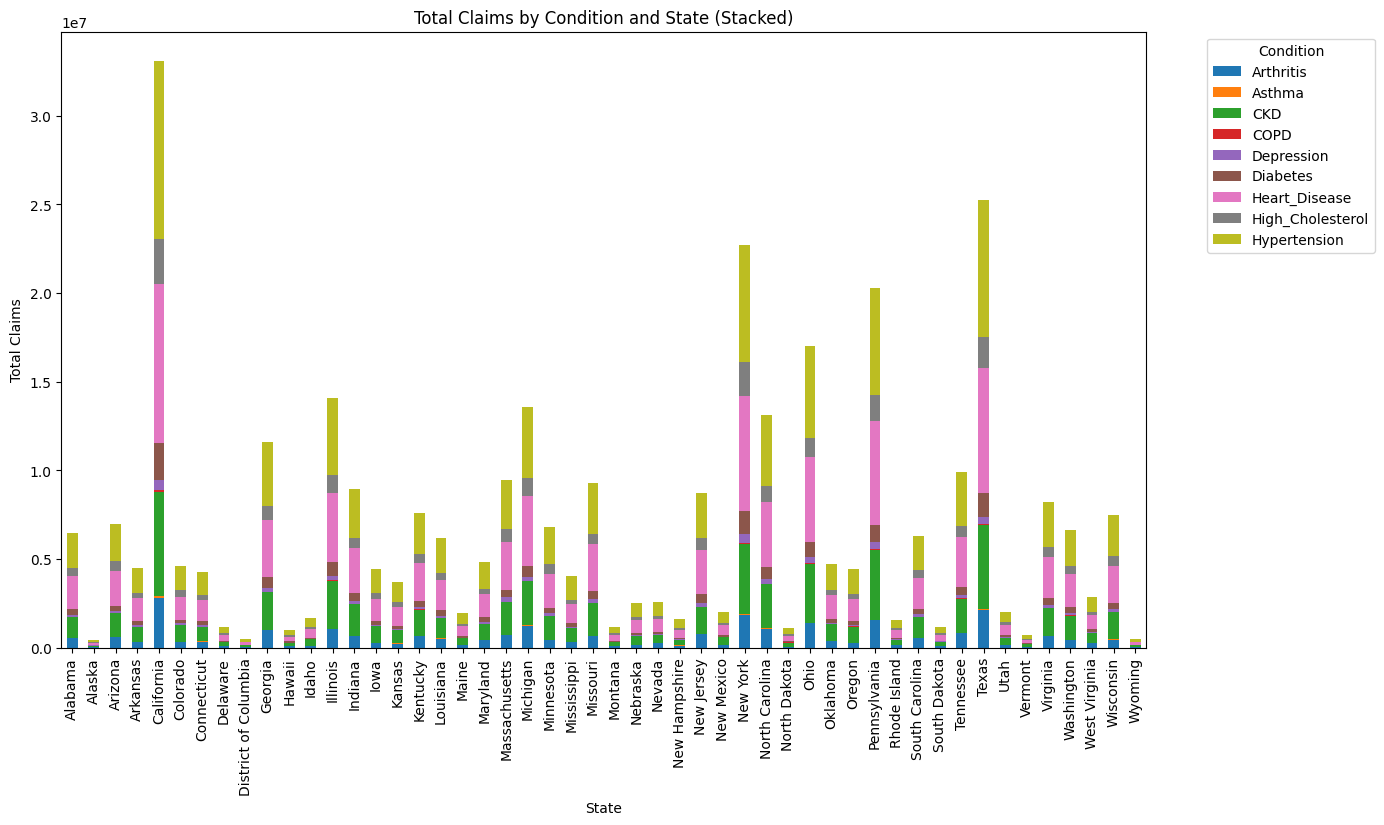

In [5]:
# SQL Query: Total Claims for Identified Drugs Across States
query = """
SELECT 
    GEO_VALUE AS State,
    Measure_Short AS Condition,
    Gnrc_Name AS Drug_Name,
    SUM(Tot_Clms) AS Total_Claims,
    AVG(Weighted_Average) AS Health_Measure_Average
FROM 
    final_merged_data
GROUP BY 
    GEO_VALUE, Measure_Short, Gnrc_Name
ORDER BY 
    Total_Claims DESC;
"""

# Load the data into a DataFrame
claims_df = pd.read_sql_query(query, conn)

# Pivot the data for a stacked bar plot
stacked_df = claims_df.pivot_table(index='State', columns='Condition', values='Total_Claims', aggfunc='sum')

# Plotting
stacked_df.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Total Claims by Condition and State (Stacked)')
plt.xlabel('State')
plt.ylabel('Total Claims')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### *2.2 Adjusted for Population*

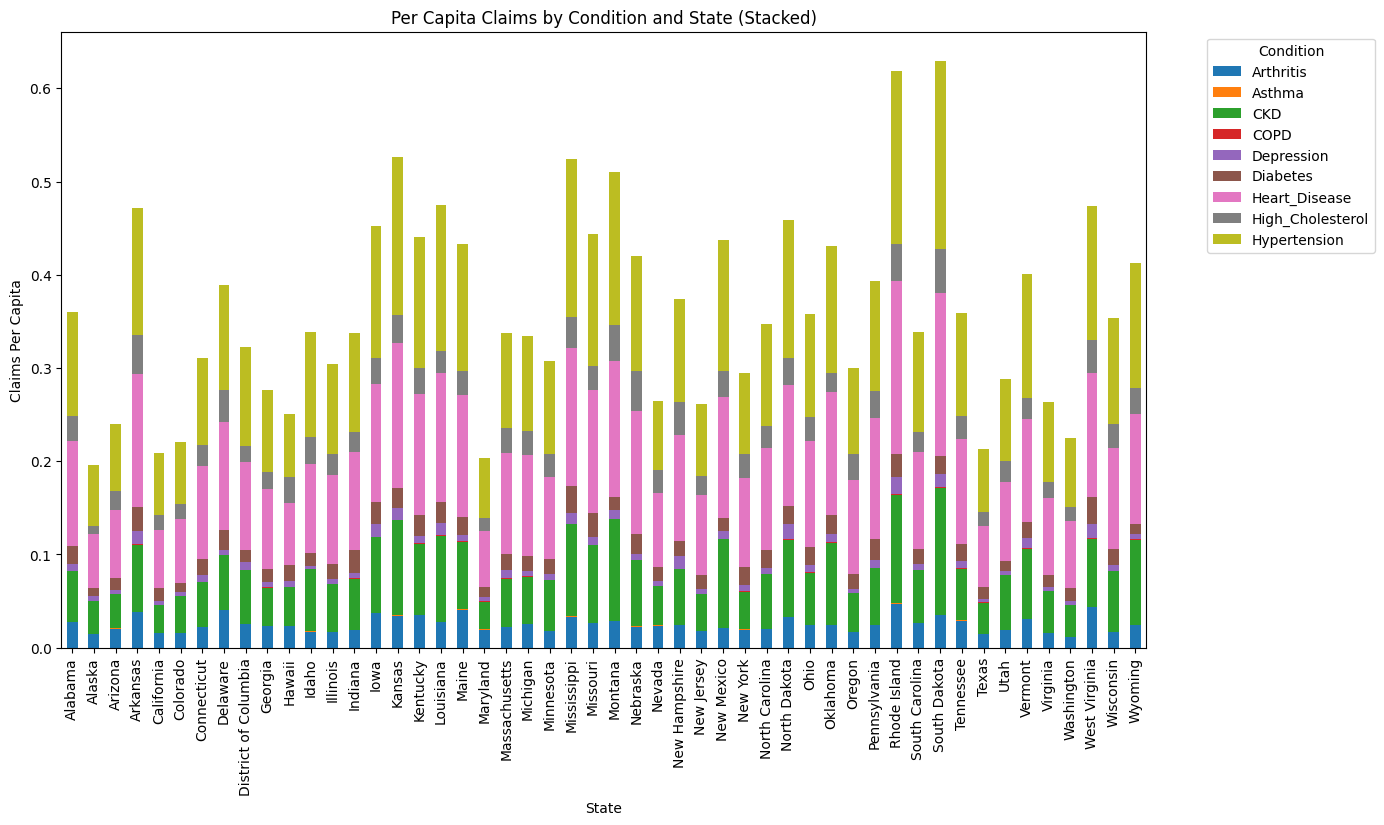

In [7]:
# SQL Query: Total Claims Per Capita for Identified Drugs Across States
query_per_capita = """
SELECT 
    GEO_VALUE AS State,
    Measure_Short AS Condition,
    Gnrc_Name AS Drug_Name,
    SUM(Tot_Clms) AS Total_Claims,
    AVG(Weighted_Average) AS Health_Measure_Average,
    SUM(Tot_Clms) / SUM(Total_Population) AS Claims_Per_Capita
FROM 
    final_merged_data
GROUP BY 
    GEO_VALUE, Measure_Short, Gnrc_Name
ORDER BY 
    Claims_Per_Capita DESC;
"""

# Load the data into a DataFrame
claims_per_capita_df = pd.read_sql_query(query_per_capita, conn)

# Pivot the data for a stacked bar plot (Per Capita)
stacked_df_per_capita = claims_per_capita_df.pivot_table(index='State', columns='Condition', values='Claims_Per_Capita', aggfunc='sum')

# Plotting the Per Capita Claims by Condition and State (Stacked)
stacked_df_per_capita.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Per Capita Claims by Condition and State (Stacked)')
plt.xlabel('State')
plt.ylabel('Claims Per Capita')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The two charts provide a comprehensive view of prescription drug claims across different states, focusing on both the total number of claims and the number of claims adjusted for population size. This analysis will explore the insights each chart offers individually and in combination.

#### **1. Total Claims by Condition and State (Stacked)**
- **Overview**: This chart shows the total number of drug claims across various conditions for each state. Each bar represents the cumulative claims for all conditions in a given state, with different colors denoting different conditions.
- **Key Observations**:
    - High Total Claims in Larger States: States like California, Texas, and Florida show significantly higher total claims. This is expected given their large populations, which naturally lead to higher absolute numbers of drug claims.
    - Hypertension Dominates: The yellow segments (Hypertension) make up the largest portion of total claims in most states, indicating that this condition is a significant driver of prescription drug use across the U.S.
    - State-Specific Trends: Some states, such as New York and Pennsylvania, have a more diverse distribution of claims across multiple conditions (e.g., Depression, Diabetes), while others like Florida are heavily skewed towards Hypertension and Heart Disease.
- **Implications**:
    - The total claims chart highlights the overall burden of chronic conditions on the healthcare system in different states, with a particular emphasis on conditions like Hypertension and Heart Disease.
    - States with the highest total claims may require more resources and targeted interventions to manage these chronic conditions effectively.
#### **2. Per Capita Claims by Condition and State (Stacked)**
- **Overview**: This chart adjusts the total claims data by the population of each state, showing the number of claims per capita. This adjustment allows for a more equitable comparison between states, regardless of population size.
- **Key Observations**:
    - High Per Capita Claims in Smaller States: States like Kentucky, West Virginia, and Alabama show high claims per capita, even though their total claims are not as high. This suggests a higher prevalence of chronic conditions or more aggressive treatment approaches in these states.
    - Variation in Condition Dominance: While Hypertension remains a significant factor, the per capita chart shows that other conditions like Depression (pink) and Diabetes (orange) also have a substantial impact in certain states. For example, West Virginia and Kentucky have high per capita claims for Diabetes and Depression.
    - Balanced Distribution: Some states, such as Vermont and Maine, have a more balanced distribution across conditions, indicating a more uniform healthcare burden across various chronic diseases.
- **Implications**:
    - The per capita analysis reveals which states have a disproportionately high burden of certain conditions, relative to their population size. This can help identify areas where healthcare resources may need to be concentrated or where public health interventions could be more effective.
    - The variation in condition dominance between states suggests that localized healthcare strategies may be necessary to address the specific needs of each population.

#### **Combined Insights**
1. **Total vs. Per Capita Perspective**: The combination of these two charts provides a dual perspective on healthcare burden—both in absolute terms and normalized for population size. This approach highlights the importance of considering both metrics when assessing healthcare needs and allocating resources.
2. **State-Specific Healthcare Challenges**: States with high total claims and high per capita claims (e.g., West Virginia, Kentucky) may face unique healthcare challenges, requiring targeted strategies to manage the high prevalence and intensity of chronic conditions.
3. **Policy Implications**: Policymakers and healthcare providers can use these insights to prioritize interventions in states with high per capita claims, ensuring that resources are directed towards areas with the greatest need relative to their population size.

#### **Conclusion**
The total claims chart underscores the sheer volume of healthcare needs in larger states, while the per capita chart reveals the relative intensity of those needs in smaller or less populous states. Together, these visuals paint a comprehensive picture of the current landscape of chronic disease management across the United States, offering valuable guidance for healthcare planning and resource allocation.

---
---

### **3. Drug Utilization Patterns by Condition and State**